In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
import joblib
plt.style.use("ggplot")
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("LCWQ_Continuous_FPSites.csv")
data.head()

,Site,Site Name,Date,Battery (V),Conductivity 25C continuous (uS/cm),Oxygen dissolved continuous (%satn),pH continuous,Temperature water continuous (C),Water level continuous (mm)
0,FP01,Bere Stream at Snatford Bridge,2002-11-13 13:45:00,12.0,405.0,117.3,8.02,11.4,450.8
1,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:00:00,12.0,405.0,117.1,8.02,11.4,451.5
2,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:15:00,12.0,405.0,116.3,8.02,11.4,450.7
3,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:30:00,12.0,405.0,115.2,8.02,11.3,450.9
4,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:45:00,12.0,405.0,114.9,8.01,11.3,451.1


In [3]:
# Creating a subset of the data and Renaming the features of the dataset 

sub_data = data.iloc[:5000, :].copy()

sub_data = sub_data.rename(columns= {
    'Site':"site",
    'Site Name':"site_name",
    'Date':"date",
    'Battery (V)':"battery",
    'Conductivity 25C continuous (uS/cm)':"conductivity",
    'Oxygen dissolved continuous (%satn)':"oxygen",
    'pH continuous':"ph",
    'Temperature water continuous (C)':"temp",
     'Water level continuous (mm)':"water_level"
})
sub_data.head()

,site,site_name,date,battery,conductivity,oxygen,ph,temp,water_level
0,FP01,Bere Stream at Snatford Bridge,2002-11-13 13:45:00,12.0,405.0,117.3,8.02,11.4,450.8
1,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:00:00,12.0,405.0,117.1,8.02,11.4,451.5
2,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:15:00,12.0,405.0,116.3,8.02,11.4,450.7
3,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:30:00,12.0,405.0,115.2,8.02,11.3,450.9
4,FP01,Bere Stream at Snatford Bridge,2002-11-13 14:45:00,12.0,405.0,114.9,8.01,11.3,451.1


In [4]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   site          5000 non-null   object 
 1   site_name     5000 non-null   object 
 2   date          5000 non-null   object 
 3   battery       5000 non-null   float64
 4   conductivity  5000 non-null   float64
 5   oxygen        5000 non-null   float64
 6   ph            5000 non-null   float64
 7   temp          5000 non-null   float64
 8   water_level   5000 non-null   float64
dtypes: float64(6), object(3)
memory usage: 351.7+ KB


In [5]:
sub_data.corr(numeric_only=True) # correlation between the features

,battery,conductivity,oxygen,ph,temp,water_level
battery,1.000000,0.458313,0.381633,0.504574,-0.129025,0.246596
conductivity,0.458313,1.000000,0.549594,0.646532,0.144615,-0.057854
oxygen,0.381633,0.549594,1.000000,0.622929,-0.146134,-0.193903
ph,0.504574,0.646532,0.622929,1.000000,-0.356340,0.009238
temp,-0.129025,0.144615,-0.146134,-0.356340,1.000000,0.249668
water_level,0.246596,-0.057854,-0.193903,0.009238,0.249668,1.000000


In [6]:
# Quick feature creation

sub_data["conductivity/battery"] = sub_data["conductivity"] / sub_data["battery"]
sub_data["water_temp"] = sub_data["water_level"] * sub_data["temp"]
sub_data["conductivity_battery"] = sub_data["conductivity"] * sub_data["battery"]
sub_data["ph_conductivity"] = sub_data["conductivity"] * sub_data["ph"]
sub_data["water_conductivity"] = sub_data["conductivity"] * sub_data["water_level"]
sub_data["ph_temp"] = sub_data["conductivity"] * sub_data["temp"]

# Correlation of the all features, including created features
sub_data.corr(numeric_only=True)["oxygen"].sort_values(ascending=False)

oxygen                  1.000000
ph                      0.622929
ph_conductivity         0.600378
conductivity_battery    0.554313
conductivity            0.549594
battery                 0.381633
conductivity/battery    0.288778
water_conductivity      0.177132
ph_temp                 0.135670
temp                   -0.146134
water_level            -0.193903
water_temp             -0.204790
Name: oxygen, dtype: float64

In [7]:
# Selection of features based on their correlation values

sub_data_useful = sub_data[['oxygen', 'ph', 'ph_conductivity', 
            'conductivity_battery', 'conductivity', 
            'battery', 'conductivity/battery', 
            'water_conductivity', "water_temp"]].copy()
sub_data_useful.head()

,oxygen,ph,ph_conductivity,conductivity_battery,conductivity,battery,conductivity/battery,water_conductivity,water_temp
0,117.3,8.02,3248.10,4860.0,405.0,12.0,33.75,182574.0,5139.12
1,117.1,8.02,3248.10,4860.0,405.0,12.0,33.75,182857.5,5147.10
2,116.3,8.02,3248.10,4860.0,405.0,12.0,33.75,182533.5,5137.98
3,115.2,8.02,3248.10,4860.0,405.0,12.0,33.75,182614.5,5095.17
4,114.9,8.01,3244.05,4860.0,405.0,12.0,33.75,182695.5,5097.43


# Data Vizualization

In [21]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log)
square_root_transformer = FunctionTransformer(lambda x: x**(1/2))
cube_root_transformer = FunctionTransformer(lambda x: x**(1/3))

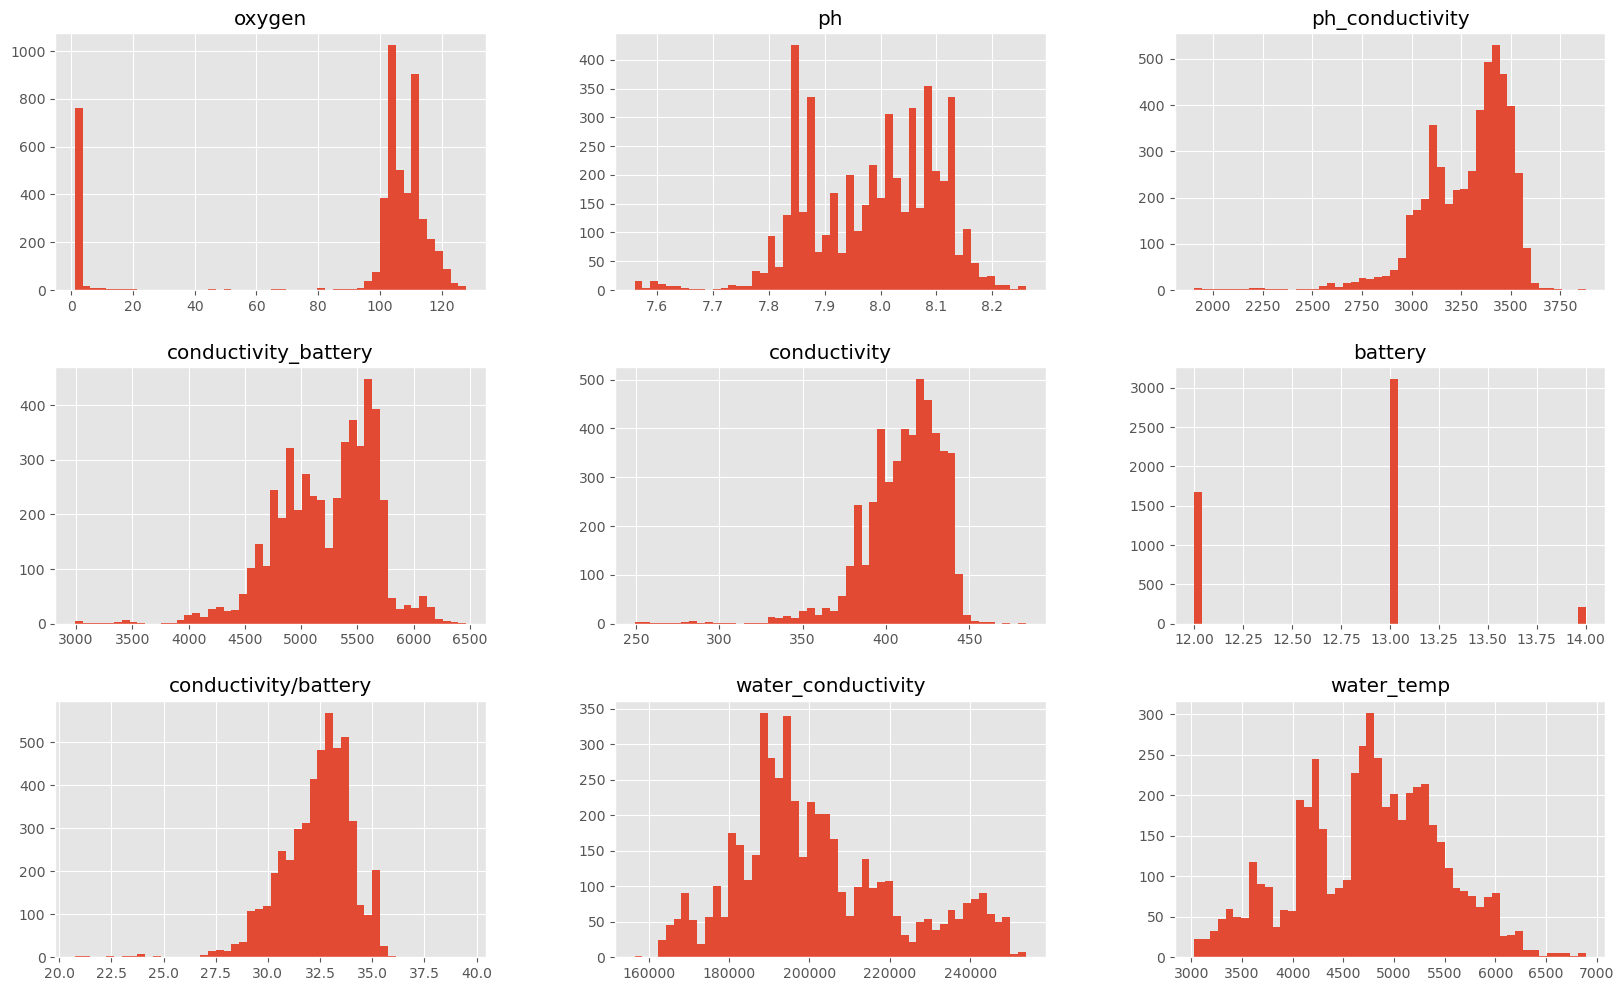

In [15]:
# Histogram of all features
sub_data_useful.hist(bins=50, figsize=(20,12))
plt.show()

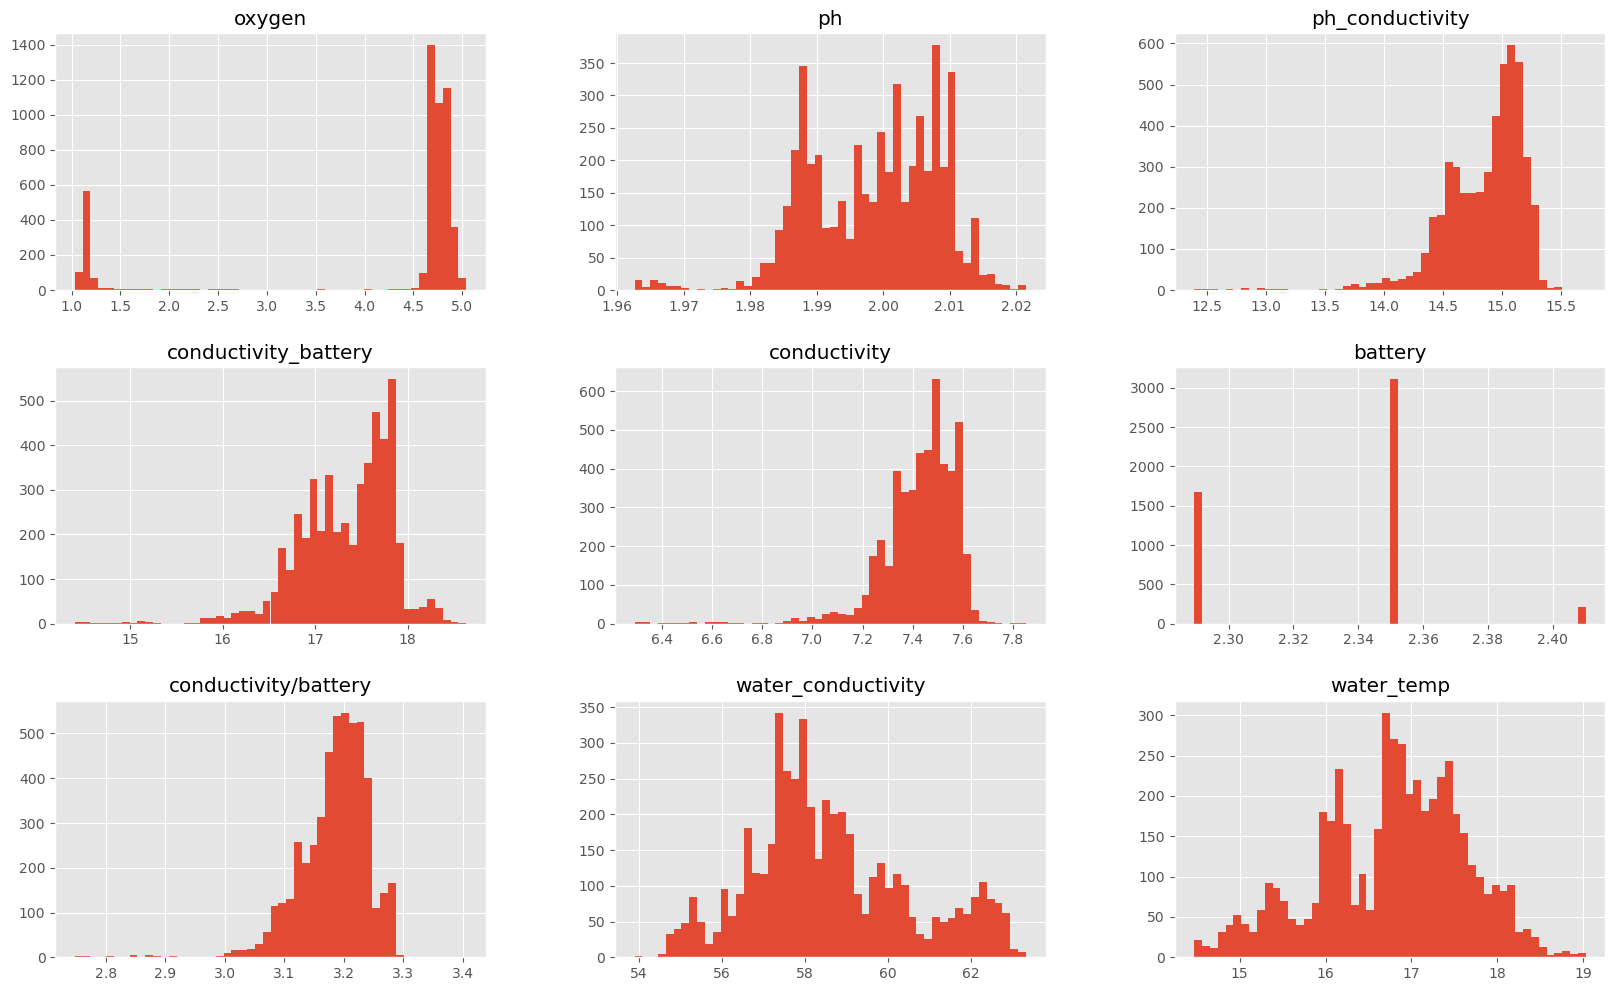

In [22]:
# Cube root transformation
cube_root_transform = cube_root_transformer.transform(sub_data_useful)
cube_root_transform.hist(bins=50, figsize=(20,12))
plt.show()

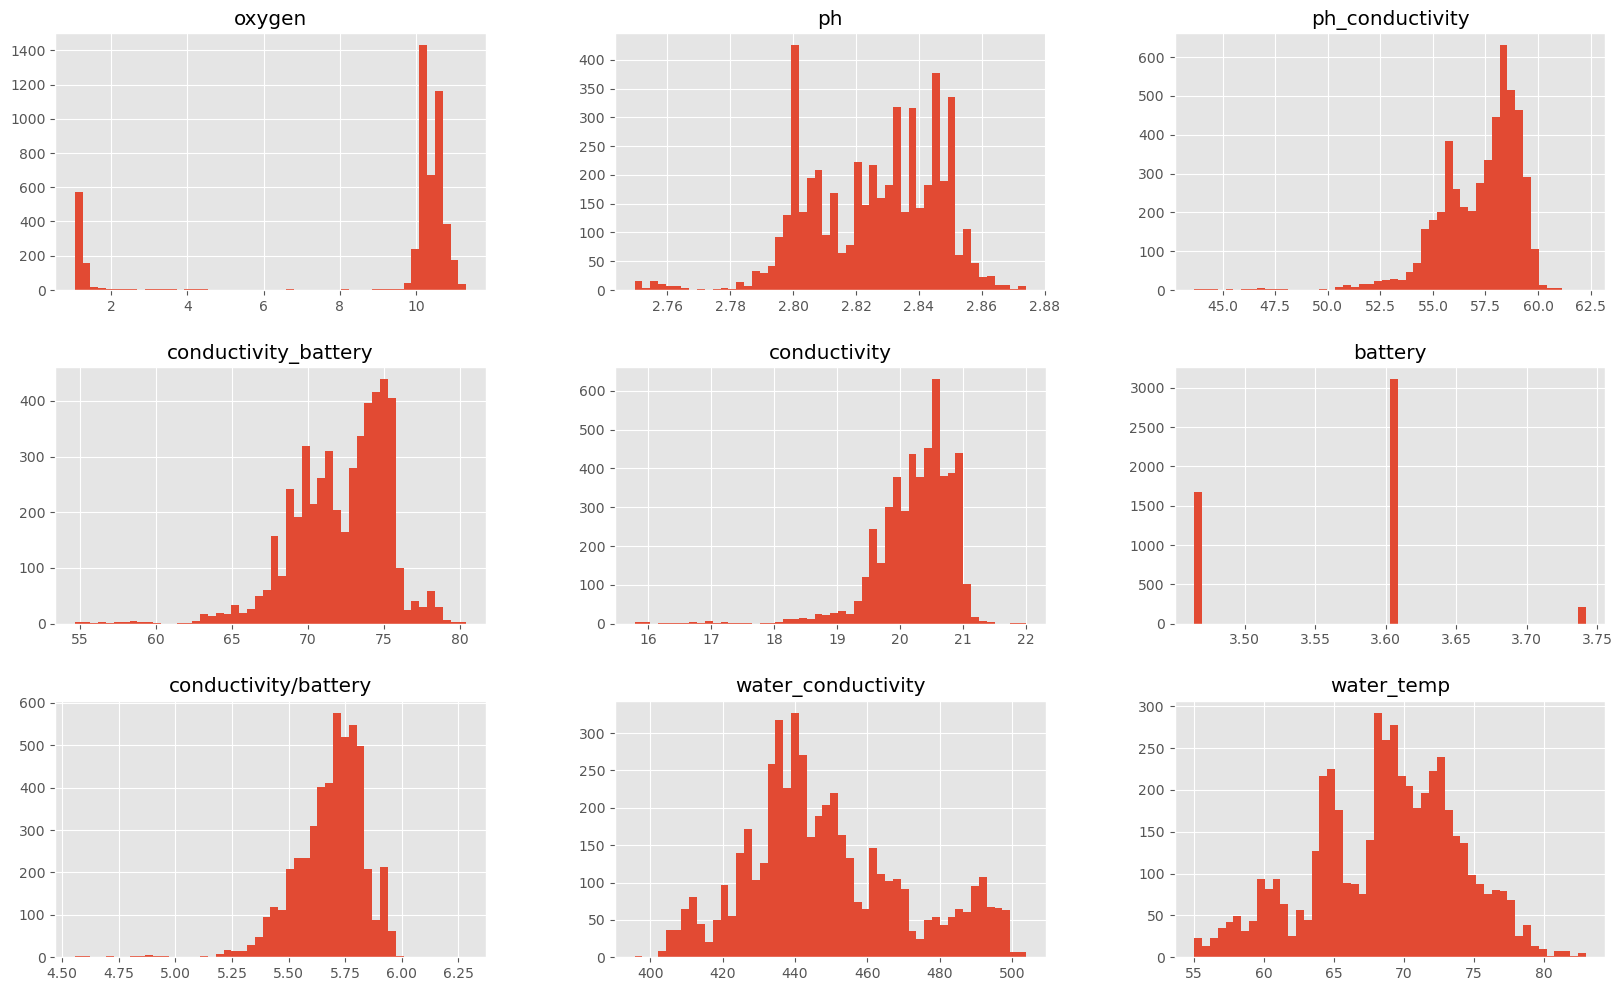

In [23]:
# Square Root Transformation
square_root_transform = square_root_transformer.transform(sub_data_useful)
square_root_transform.hist(bins=50, figsize=(20,12))
plt.show()

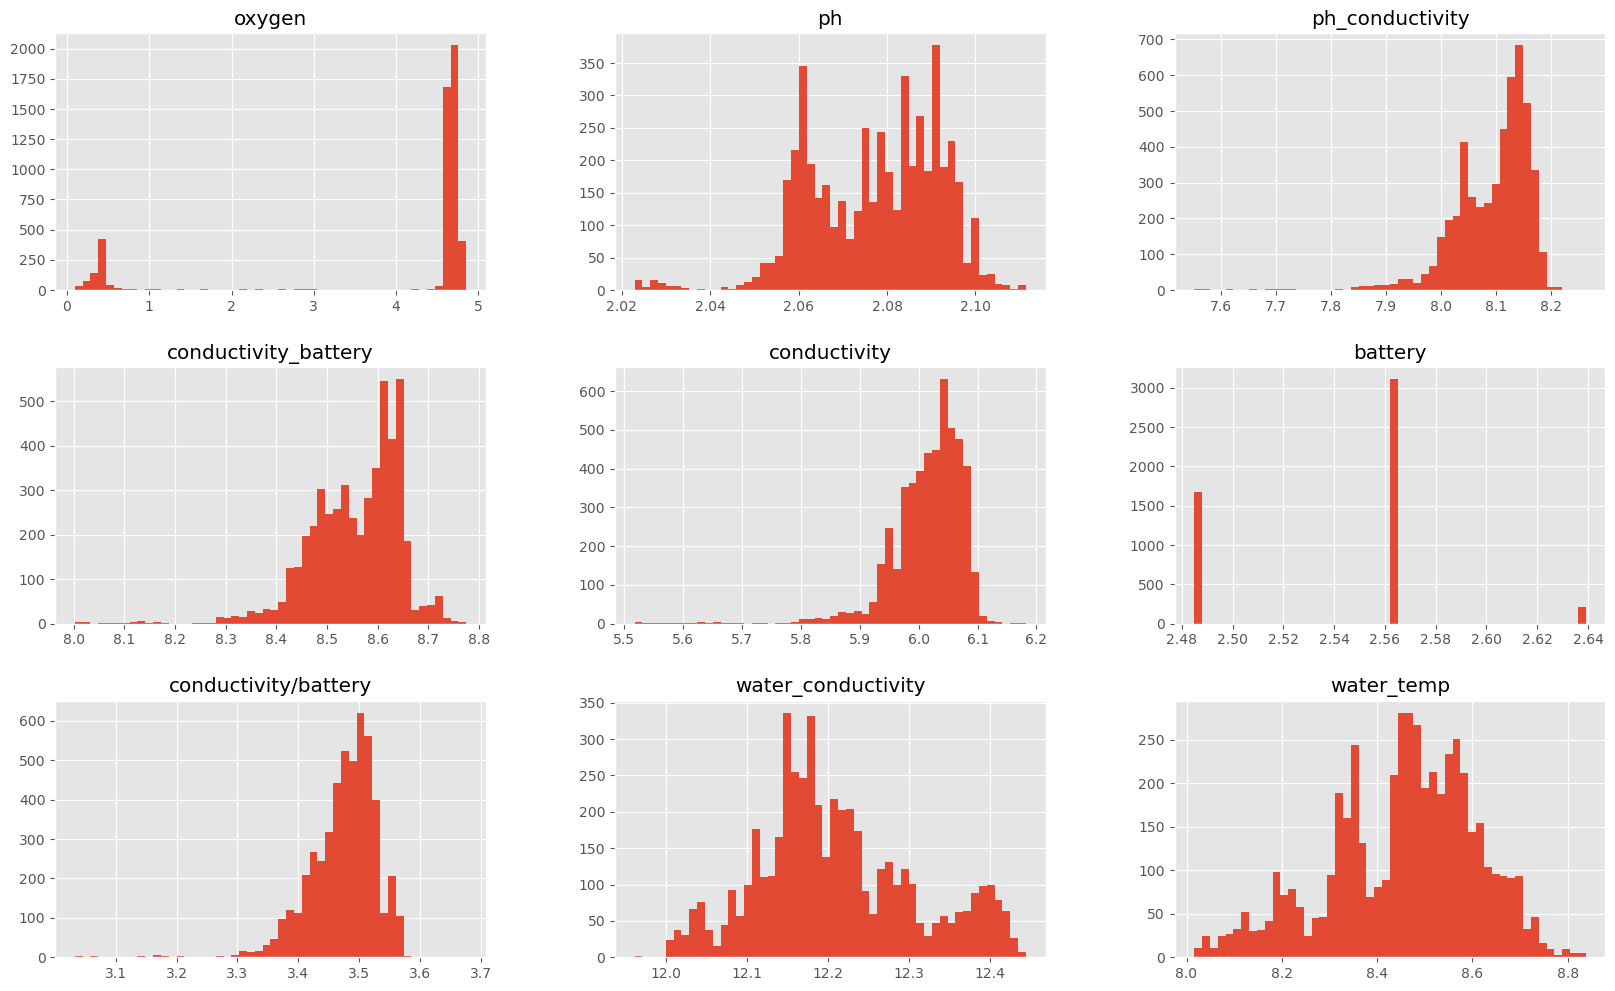

In [24]:
# Natural Log Transformation
log_transform = log_transformer.transform(sub_data_useful)
log_transform.hist(bins=50, figsize=(20,12))
plt.show()

# Preprocessing

In [8]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

In [9]:
# Train-Test split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(sub_data_useful, test_size=0.2, random_state=42, stratify=sub_data_useful["battery"])
X_train, y_train = train_set.drop(["oxygen"], axis=1), train_set["oxygen"]
X_test, y_test = test_set.drop(["oxygen"], axis=1), test_set["oxygen"]

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class input_outlier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        a=False
        if a:
            self.feature_names_in = X.columns
        else:
            self.feature_names_in = [str(i) for i in range(X.shape[1])]
            
        self.upper_limit = np.percentile(X, 99)
        self.lower_limit = np.percentile(X, 1)
        
        #--> for pandas
        #self.upper_limit = X.quantile(0.99)
        #self.lower_limit = X.quantile(0.01)
        return self
    def transform(self, X, y=None):
        fixed_X = np.where(X>self.upper_limit, self.upper_limit, np.where(X<self.lower_limit, self.lower_limit, X))
        return fixed_X
    def get_feature_names_out(self, names=None):
        return self.feature_names_in

In [11]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out="one-to-one")

num_features = make_pipeline(
    input_outlier(),
    SimpleImputer(strategy="median"),
    log_transformer,
    StandardScaler(),
)

cat_features = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="error")
)

cleaning = ColumnTransformer([
    #("cat", cat_features, ("battery",)),
    ("num", num_features, make_column_selector(dtype_include=np.number))
])

target_cleaning = make_pipeline(
    input_outlier(),
    SimpleImputer(strategy="median"),
    log_transformer,
    StandardScaler(),
)

class target_cleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.fix_outlier = input_outlier()
        self.imputer = SimpleImputer(strategy="median")
        self.scaler = StandardScaler()
        self.log_transformer = FunctionTransformer(np.log)
        self.exp_transformer = FunctionTransformer(np.exp)

        return self
    
    def transform(self, X, y=None):
        fixed_outlier = self.fix_outlier.fit_transform(X)
        fixed_missing = self.imputer.fit_transform(fixed_outlier)
        fixed_log = self.log_transformer.transform(fixed_missing)
        fixed_scale = self.scaler.fit_transform(fixed_log)
        
        return fixed_scale
    
    def inverse_transform(self, X, y=None):
        X_unscaled = self.scaler.inverse_transform(X)
        X_unlog = self.exp_transformer.transform(X_unscaled)
        return X_unlog
    
mse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False, needs_threshold=False)

In [12]:
cleaning.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('input_outlier',
                                                  input_outlier()),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'exp'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000021385EEC700>)])

In [13]:
X_train_clean = cleaning.fit_transform(X_train)
X_test_clean = cleaning.transform(X_test)

In [32]:
# save cleaning preprocessor
joblib.dump(cleaning, "trained_models/cleaning.plk")

['trained_models/cleaning.plk']

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor
random_frst = Pipeline([
    ("cleaning", cleaning),
    ("poly_feat", PolynomialFeatures(degree=2)),
    ("forest", RandomForestRegressor())
])

In [35]:
cross_score = cross_val_score(random_frst, X=X_train, y=y_train, cv=5, scoring=mse_scorer, n_jobs=-1)
cross_score.mean()

7.6753458935182355

### Random Forest Grid Search

In [36]:
params = [{"forest__n_estimators":[100, 150, 200], 
           "forest__criterion":["friedman_mse"],
          "forest__max_depth": [25, 30, 35],
          "forest__min_samples_split": [2, 3],
          "forest__max_features": [7, 9, 10],
          "forest__n_jobs": [-1],
          }]

forest_grid_search = GridSearchCV(random_frst, cv=3, param_grid = params, n_jobs=-1, verbose=2, scoring=mse_scorer)

In [37]:
forest_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cleaning',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('input_outlier',
                                                                                          input_outlier()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>,
                                                                                                              inverse_func=<ufunc 'exp'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler()...
                                       ('poly_feat', PolynomialFeatures()),
                                       ('forest', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'forest__criterion': ['friedman_mse'],
                          'forest__max_depth': [25, 30, 35],
                          'forest__max_features': [7, 9, 10],
                          'forest__min_samples_split': [2, 3],
                          'forest__n_estimators': [100, 150, 200],
                          'forest__n_jobs': [-1]}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=2)

In [26]:
pd.DataFrame(forest_grid_search.cv_results_).sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__bootstrap,param_forest__ccp_alpha,param_forest__criterion,param_forest__max_depth,param_forest__max_features,param_forest__min_samples_split,param_forest__n_estimators,param_forest__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,4.760197,0.203449,0.937458,0.43878,False,0,friedman_mse,25,9,2,150,-1,"{'forest__bootstrap': False, 'forest__ccp_alph...",7.231413,6.856122,7.147053,7.078196,0.160763,36


### Final Random Forest Model

In [15]:
final_rand_frst = Pipeline([("cleaning", cleaning), 
                                            ("poly_feat", PolynomialFeatures(degree=2)), 
                                            ("forest", RandomForestRegressor(ccp_alpha=0, criterion='friedman_mse', 
                                                                             max_features=9, max_depth=25, 
                                                                             min_samples_split=2, 
                                                                             n_estimators=150, 
                                                                             n_jobs=-1, 
                                                                             bootstrap=False))])

final_rand_frst_cv = cross_val_score(final_rand_frst, X=X_train, y=y_train, cv=5, scoring=mse_scorer)
final_rand_frst_cv.mean()

6.431861916492119

In [16]:
# fitting the final random forest model
final_rand_frst.fit(X_train, y_train)

Pipeline(steps=[('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('input_outlier',
                                                                   input_outlier()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226A5841060>)])),
                ('poly_feat', PolynomialFeatures()),
                ('forest',
                 RandomForestRegressor(bootstrap=False, ccp_alpha=0,
                                       criterion='friedman_mse', max_depth=25,
                                       max_features=9, n_estimators=150,
                                       n_jobs=-1))])

In [18]:
mean_squared_error(y_test, final_rand_frst.predict(X_test), squared=False)

5.84519396327744

In [49]:
# Saving fine-runed random forest model
joblib.dump(final_rand_frst, "trained_models/fish_RandomForest.plk")

['trained_models/fish_RandomForest.plk']

# SVM

In [19]:
svm_reg = Pipeline([
    ("cleaning", cleaning),
    ("svm", SVR())
])

In [51]:
cross_score = cross_val_score(svm_reg, X=X_train, y=y_train, cv=5, scoring=mse_scorer)
cross_score.mean()

23.846614841729835

### SVM Grid Search

In [36]:
params = [{
    "svm__kernel":["rbf"],
    "svm__gamma":[2, 3],
    "svm__C":[800, 900],
    "svm__epsilon":[1,2]
}]

svm_grid_search = GridSearchCV(svm_reg, param_grid=params, cv=3, n_jobs=-1, verbose=2, scoring=mse_scorer)

In [37]:
svm_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cleaning',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('input_outlier',
                                                                                          input_outlier()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>,
                                                                                                              inverse_func=<ufunc 'exp'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000015E531480A0>)])),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid=[{'svm__C': [800, 900], 'svm__epsilon': [1, 2],
                          'svm__gamma': [2, 3], 'svm__kernel': ['rbf']}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=2)

In [40]:
svm_grid_results = pd.DataFrame(svm_grid_search.cv_results_)
svm_grid_results.sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__epsilon,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,7.38898,0.754241,0.307278,0.007365,800,1,2,rbf,"{'svm__C': 800, 'svm__epsilon': 1, 'svm__gamma...",6.941438,6.159607,5.182666,6.09457,0.719487,8


## FInal SVM Model

In [20]:
final_svm_reg = Pipeline([
    ("cleaning", cleaning),
    ("svm", SVR(C=800, epsilon=1, gamma=2, kernel="rbf"))
])

#final_svm = SVR(C=800, epsilon=1, gamma=2, kernel="rbf")

In [21]:
final_svm_reg_cv = cross_val_score(final_svm_reg, X=X_train, y=y_train, cv=5, scoring=mse_scorer)
final_svm_reg_cv.mean()

5.0626326415649645

In [22]:
# fit final svm model
final_svm_reg.fit(X_train, y_train)

Pipeline(steps=[('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('input_outlier',
                                                                   input_outlier()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000226A5841060>)])),
                ('svm', SVR(C=800, epsilon=1, gamma=2))])

In [25]:
mean_squared_error(y_test, final_svm_reg.predict(X_test), squared=False)

4.705967709317049

In [57]:
joblib.dump(final_svm_reg, "trained_models/fish_SVM.plk")

['trained_models/fish_SVM.plk']

# Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
lin_reg = Pipeline([
    ("cleaning", cleaning),
    ("lin_reg", LinearRegression())
])

In [68]:
cross_score = cross_val_score(lin_reg, X=X_train, y=y_train, cv=5, scoring=mse_scorer)
cross_score.mean()

28.409748305022855

# ADABoosting for SVM

In [14]:
svm_for_ada = SVR(C=800, epsilon=1, gamma=2, kernel="rbf")
ada_reg = AdaBoostRegressor(svm_for_ada, n_estimators=50, learning_rate=1, loss="square")

In [15]:
ada_reg_cv = cross_val_score(ada_reg, X=X_train_clean, y=y_train, cv=2, scoring=mse_scorer, n_jobs=-1)
ada_reg_cv.mean()

8.453845417583306

In [16]:
params = [{
    "n_estimators":[10,5],
    "learning_rate":[0.1, 0.3, 0.2],
    "loss":["exponential", "square"]
}]

ada_reg_grid = GridSearchCV(ada_reg, param_grid=params, n_jobs=-1, cv=3, scoring=mse_scorer, verbose=1)

In [17]:
ada_reg_grid.fit(X_train_clean, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                       gamma=2),
                                         learning_rate=1, loss='square'),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.3, 0.2],
                          'loss': ['exponential', 'square'],
                          'n_estimators': [10, 5]}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [18]:
pd.DataFrame(ada_reg_grid.cv_results_).sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,61.804606,1.381815,4.13949,0.279557,0.2,square,10,"{'learning_rate': 0.2, 'loss': 'square', 'n_es...",7.395529,6.327857,5.250081,6.324489,0.875879,12


In [16]:
final_ada_reg = AdaBoostRegressor(svm_for_ada, n_estimators=10, loss="square", learning_rate=0.2)

In [17]:
final_ada_cv = cross_val_score(final_ada_reg, X=X_train_clean, y=y_train, cv=3, scoring=mse_scorer)
final_ada_cv.mean()

6.4666297613682415

In [19]:
joblib.dump(final_ada_reg, "trained_models/fish_AdaBoost.plk")

['trained_models/fish_AdaBoost.plk']

# Gradient Boosting

In [20]:
grbt_reg = GradientBoostingRegressor()

In [23]:
grbt_reg_cv = cross_val_score(grbt_reg, X=X_train_clean, y=y_train, cv=3, scoring=mse_scorer)
grbt_reg_cv.mean()

10.022187134644872

In [34]:
params = [{
    "loss":["absolute_error"],
    "learning_rate":[0.1, 0.01],
    "criterion":['friedman_mse'],
    "max_depth":[5, 10],
    "max_features":[3],
    "n_estimators":[50, 100,200, 400],
    "verbose":[1],
    "n_iter_no_change": [10]
}]

grbt_reg_grid = GridSearchCV(grbt_reg, param_grid=params, cv=3, n_jobs=-1, scoring=mse_scorer, verbose=3)

In [35]:
grbt_reg_grid.fit(X_train_clean, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
      Iter       Train Loss   Remaining Time 
         1          20.7869            2.55s
         2          20.5509            2.52s
         3          20.3960            2.38s
         4          20.2539            2.31s
         5          20.1121            2.36s
         6          19.8958            2.40s
         7          19.6922            2.41s
         8          19.5110            2.33s
         9          19.3731            2.29s
        10          19.2337            2.27s
        20          17.9257            1.69s
        30          16.6892            1.10s
        40          15.6213            0.55s
        50          14.5352            0.00s


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['friedman_mse'],
                          'learning_rate': [0.1, 0.01],
                          'loss': ['absolute_error'], 'max_depth': [5, 10],
                          'max_features': [3],
                          'n_estimators': [50, 100, 200, 400],
                          'n_iter_no_change': [10], 'verbose': [1]}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=3)

In [36]:
pd.DataFrame(grbt_reg_grid.cv_results_).sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_n_estimators,param_n_iter_no_change,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,33.290085,4.09488,0.044292,0.009022,friedman_mse,0.1,absolute_error,10,3,400,10,1,"{'criterion': 'friedman_mse', 'learning_rate':...",6.905296,7.415338,7.332493,7.217709,0.223483,16


In [27]:
pd.DataFrame(grbt_reg_grid.cv_results_).sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_n_estimators,param_n_iter_no_change,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
32,10.848259,1.54501,0.015319,0.002621,friedman_mse,0.1,absolute_error,10,3,200,10,1,"{'criterion': 'friedman_mse', 'learning_rate':...",7.426,6.954485,6.871751,7.084079,0.244123,288


In [119]:
pd.DataFrame(grbt_reg_grid.cv_results_).sort_values(by="mean_test_score", ascending=True).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_n_estimators,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,37.310782,0.650991,0.057288,0.007367,squared_error,0.1,absolute_error,10,5,900,1,"{'criterion': 'squared_error', 'learning_rate'...",6.597483,5.920809,7.316557,6.611616,0.5699,16


In [42]:
final_grbt_reg = GradientBoostingRegressor(n_estimators=900, max_features=5, max_depth=10, learning_rate=0.1,
                                          loss="absolute_error", criterion="squared_error")

In [43]:
final_grbt_reg_cv = cross_val_score(final_grbt_reg, X=X_train_clean, y=y_train, cv=3, scoring=mse_scorer)
final_grbt_reg_cv.mean()

7.481553117055558

In [37]:
final_grbt_reg = GradientBoostingRegressor(n_estimators=1100, max_features=5, max_depth=10,
                                          loss="absolute_error", criterion="squared_error")

In [38]:
final_grbt_reg_cv = cross_val_score(final_grbt_reg, X=X_train_clean, y=y_train, cv=3, scoring=mse_scorer)
final_grbt_reg_cv.mean()

7.319688106537701

## All Fine-tuned Models

In [35]:
final_random_forest =RandomForestRegressor(ccp_alpha=0, criterion='squared_error', 
                                           max_features="sqrt", max_depth=20, 
                                           min_samples_split=3, n_estimators=30, 
                                           n_jobs=-1)

final_svm = SVR(C=800, epsilon=1, gamma=2, kernel="rbf")

final_ada_reg = AdaBoostRegressor(final_svm, n_estimators=10, loss="exponential", learning_rate=0.3)

final_grbt_reg = GradientBoostingRegressor(n_estimators=1100, max_features=5, max_depth=10,
                                          loss="absolute_error", criterion="squared_error")
voting_reg = VotingRegressor(estimators=[("random_forest", final_random_forest),
                                         ("svm", final_svm),
                                         ("adaBoost", final_ada_reg),
                                         ("grbt", final_grbt_reg)
])


In [36]:
final_random_forest.fit(X_train_clean, y_train)
final_svm.fit(X_train_clean, y_train)
final_ada_reg.fit(X_train_clean, y_train)
final_grbt_reg.fit(X_train_clean, y_train)
voting_reg.fit(X_train_clean, y_train)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(ccp_alpha=0, max_depth=20,
                                                   max_features='sqrt',
                                                   min_samples_split=3,
                                                   n_estimators=30,
                                                   n_jobs=-1)),
                            ('svm', SVR(C=800, epsilon=1, gamma=2)),
                            ('adaBoost',
                             AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                             gamma=2),
                                               learning_rate=0.3,
                                               loss='exponential',
                                               n_estimators=10)),
                            ('grbt',
                             GradientBoostingRegressor(criterion='squared_error',
                                                       loss='absolute_error',
                                                       max_depth=10,
                                                       max_features=5,
                                                       n_estimators=1100))])

In [37]:
joblib.dump(final_random_forest, "trained_models/RandomForest.plk")
joblib.dump(final_svm, "trained_models/SVM.plk")
joblib.dump(final_ada_reg, "trained_models/AdaBoost.plk")
joblib.dump(final_grbt_reg, "trained_models/GradientBoost.plk")
joblib.dump(voting_reg, "trained_models/VotingReg.plk")

['trained_models/VotingReg.plk']

# Voting Classifier

In [131]:
voting_reg_cv = cross_val_score(voting_reg, X=X_train_clean, y=y_train, cv=5, scoring=mse_scorer)
voting_reg_cv.mean()

5.270647247786689

## Fine-tune Stack 1

In [19]:
rf_pred = final_random_forest.predict(X_train_clean)
svm_pred = final_svm.predict(X_train_clean)
ada_pred = final_ada_reg.predict(X_train_clean)
grbt_pred = final_grbt_reg.predict(X_train_clean)

In [21]:
sub_pred_array = np.c_[rf_pred, svm_pred, ada_pred, grbt_pred, y_train.values]
sub_pred_columns = ["random_forest", "svm", "ada_boost", "gradient_boost", "oxygen"]
sub_pred_df = pd.DataFrame(sub_pred_array, columns=sub_pred_columns)
sub_pred_df.head()

,random_forest,svm,ada_boost,gradient_boost,oxygen
0,110.834714,110.556751,110.409815,110.980375,111.0
1,120.496278,120.446505,120.399774,121.416064,121.4
2,106.813346,107.078489,107.052083,106.849362,107.2
3,105.442652,104.699919,104.700178,105.230540,105.7
4,22.118611,0.499525,0.499803,1.497720,1.5


In [23]:
sub_X_train, sub_y_train = sub_pred_df.iloc[:,:-1], sub_pred_df.iloc[:,-1]

In [26]:
sub_pred_df.to_csv("stacking_data.csv", index=False)

In [28]:
sub_pred = pd.read_csv("stacking_data.csv")
sub_X_train, sub_y_train = sub_pred_df.iloc[:,:-1], sub_pred_df.iloc[:,-1]

### Sub random forest

In [30]:
sub_random_forest = RandomForestRegressor()

In [34]:
cross_score=cross_val_score(sub_random_forest, cv=3, X=sub_X_train, y=sub_y_train, scoring=mse_scorer)
cross_score.mean()

1.0175956340711771

In [47]:
params = [{"n_estimators":[20, 15], 
           "criterion":["absolute_error", "friedman_mse"],
          "max_depth": [10, 7],
          "min_samples_split": [2, 1],
          "max_features": [3, 2, 5],
          "n_jobs": [-1],
          "ccp_alpha": [0],
           "bootstrap": [False],
          }]

sub_forest_grid_search = GridSearchCV(sub_random_forest, cv=3, 
                                      param_grid = params, n_jobs=-1, 
                                      verbose=2, scoring=mse_scorer)

In [48]:
sub_forest_grid_search.fit(sub_X_train, sub_y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'bootstrap': [False], 'ccp_alpha': [0],
                          'criterion': ['absolute_error', 'friedman_mse'],
                          'max_depth': [10, 7], 'max_features': [3, 2, 5],
                          'min_samples_split': [2, 1], 'n_estimators': [20, 15],
                          'n_jobs': [-1]}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=2)

In [49]:
sub_forest_grid_result = sub_forest_grid_search.cv_results_
pd.DataFrame(sub_forest_grid_result).sort_values(by="mean_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
26,0.272489,0.015962,0.078122,0.012757,False,0,friedman_mse,10,3,1,20,-1,"{'bootstrap': False, 'ccp_alpha': 0, 'criterio...",1.031215,1.228839,0.894714,1.051589,0.137165,48
25,0.296508,0.103947,0.131561,0.015780,False,0,friedman_mse,10,3,2,15,-1,"{'bootstrap': False, 'ccp_alpha': 0, 'criterio...",1.092656,1.273897,0.846569,1.071041,0.175124,47
3,4.491948,0.337113,1.044410,0.630794,False,0,absolute_error,10,3,1,15,-1,"{'bootstrap': False, 'ccp_alpha': 0, 'criterio...",1.107645,1.158406,0.958340,1.074797,0.084915,46


In [54]:
estimators = [
    ("random_forest", final_random_forest),
    ("svm", final_svm),
    ("adaBoost", final_ada_reg),
    ("grbt", final_grbt_reg)
]

stacking_regressor_1_1 = StackingRegressor(estimators=estimators, 
                                       final_estimator=RandomForestRegressor(n_estimators=20,
                                                                            n_jobs=-1, min_samples_split=1,
                                                                            max_features=3, max_depth=10,
                                                                            criterion="friedman_mse", bootstrap=False,
                                                                            ))
stacking_regressor

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(ccp_alpha=0, max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_split=3,
                                                     n_estimators=30,
                                                     n_jobs=-1)),
                              ('svm', SVR(C=800, epsilon=1, gamma=2)),
                              ('adaBoost',
                               AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                               gamma=2),
                                                 learning_rate=0.3,
                                                 loss='exponential',
                                                 n_estimators=10)),
                              ('grbt',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         max_depth=10,
                                                         max_features=5,
                                                         n_estimators=1100))],
                  final_estimator=RandomForestRegressor(bootstrap=False,
                                                        criterion='friedman_mse',
                                                        max_depth=10,
                                                        max_features=3,
                                                        min_samples_split=1,
                                                        n_estimators=20,
                                                        n_jobs=-1))

In [56]:
cross_score=cross_val_score(stacking_regressor_1_1, cv=3, X=X_train_clean, y=y_train, scoring=mse_scorer)
cross_score.mean()

5.5602338526116775

In [67]:
stacking_regressor_1_1.fit(X_train_clean, y_train)

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(ccp_alpha=0, max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_split=3,
                                                     n_estimators=30,
                                                     n_jobs=-1)),
                              ('svm', SVR(C=800, epsilon=1, gamma=2)),
                              ('adaBoost',
                               AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                               gamma=2),
                                                 learning_rate=0.3,
                                                 loss='exponential',
                                                 n_estimators=10)),
                              ('grbt',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         max_depth=10,
                                                         max_features=5,
                                                         n_estimators=1100))],
                  final_estimator=RandomForestRegressor(bootstrap=False,
                                                        criterion='friedman_mse',
                                                        max_depth=10,
                                                        max_features=3,
                                                        min_samples_split=1,
                                                        n_estimators=20,
                                                        n_jobs=-1))

In [70]:
joblib.dump(stacking_regressor_1_1, "trained_models/Stack1.plk")

['trained_models/Stack1.plk']

## Fine-tune stack 2

In [23]:
# get cross validation prediction of all the models
random_forest_cv_pred = cross_val_predict(final_random_forest, X=X_train_clean, y=y_train,method="predict")
svm_cv_pred = cross_val_predict(final_svm, X=X_train_clean, y=y_train, method="predict")
ada_pred = cross_val_predict(final_ada_reg, X=X_train_clean, y=y_train, method="predict")
grbt_cv_pred = cross_val_predict(final_grbt_reg, X=X_train_clean, y=y_train, method="predict")

#create data to train the blender for stacking ensembler
blender_X_train = np.c_[random_forest_cv_pred, svm_cv_pred, ada_pred, grbt_cv_pred]
columns = ["random_forest", "svm", "ada_boost", "grbt"]
blender_data = pd.DataFrame(blender_X_train, columns=columns)

blender_data.to_csv("blender_data1.csv", index=False) # save blender data to csv

In [19]:
blender_data=pd.read_csv("blender_data1.csv")

In [20]:
random_forest_blender = RandomForestRegressor()

In [37]:
cross_score = cross_val_score(random_forest_blender, X=blender_data, y=y_train, cv=3, scoring=mse_scorer)
cross_score.mean()

4.760093471426114

In [106]:
# Fine-tune the Blender

params = [{"n_estimators":[80, 100], 
           "criterion":["absolute_error", "friedman_mse", "squared_error"],
           "max_depth": [10, 7], 
           "min_samples_split": [3, 2, 1], 
           "max_features": [3, 2, 1], 
           "n_jobs": [-1], 
           "ccp_alpha": [0], 
           "bootstrap": [False, True],
           "max_samples":[50,100]
          }]

params2 = [{"n_estimators":[5000], 
           "criterion":["friedman_mse", ],
           "max_depth": [100, 200], 
           "min_samples_split": [2, 8], 
           "max_features": [1,2], 
           "n_jobs": [-1], 
           "ccp_alpha": [0], 
           "bootstrap": [True],
           "max_samples":[2000]
          }]

random_forest_blender_grid_search = GridSearchCV(random_forest_blender, 
                                                 cv=3, 
                                                 param_grid=params2, 
                                                 n_jobs=-1, 
                                                 verbose=2,
                                                 scoring=mse_scorer)
# increase max_features and max_samples, reduce max_depth

In [107]:
random_forest_blender_grid_search.fit(blender_data, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'ccp_alpha': [0],
                          'criterion': ['friedman_mse'],
                          'max_depth': [100, 200], 'max_features': [1, 2],
                          'max_samples': [2000], 'min_samples_split': [2, 8],
                          'n_estimators': [5000], 'n_jobs': [-1]}],
             scoring=make_scorer(mean_squared_error, squared=False), verbose=2)

In [108]:
random_forest_blender_grid_results = random_forest_blender_grid_search.cv_results_
pd.DataFrame(random_forest_blender_grid_results).sort_values(by="mean_test_score", ascending=True).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_max_samples,param_min_samples_split,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,70.171920,1.196871,3.958152,0.626315,True,0,friedman_mse,200,1,2000,2,5000,-1,"{'bootstrap': True, 'ccp_alpha': 0, 'criterion...",4.708354,4.035841,4.490389,4.411528,0.280158,8
0,72.858223,0.570566,2.567590,0.261859,True,0,friedman_mse,100,1,2000,2,5000,-1,"{'bootstrap': True, 'ccp_alpha': 0, 'criterion...",4.723450,4.018497,4.515765,4.419237,0.295779,7
5,57.717438,2.732298,3.564757,0.692632,True,0,friedman_mse,200,1,2000,8,5000,-1,"{'bootstrap': True, 'ccp_alpha': 0, 'criterion...",4.789727,3.999457,4.585211,4.458132,0.334906,6


In [17]:
final_random_forest_blender = RandomForestRegressor(n_estimators=5000, 
                                                    min_samples_split=2,
                                                   n_jobs=-1,
                                                   max_samples=2000,
                                                   max_features=1,
                                                   max_depth=200,
                                                   criterion="friedman_mse",
                                                   bootstrap=True,
                                                   ccp_alpha=0)

In [22]:
cross_score = cross_val_score(final_random_forest_blender, X=blender_data, y=y_train, cv=3, scoring=mse_scorer)
cross_score.mean()

4.416756014061174

In [20]:
estimators = [
    ("random_forest", final_random_forest),
    ("svm", final_svm),
    ("adaBoost", final_ada_reg),
    ("grbt", final_grbt_reg)
]

stacking_regressor_1_2 = StackingRegressor(estimators=estimators, 
                                       final_estimator=RandomForestRegressor(n_estimators=5000, 
                                                    min_samples_split=2,
                                                   n_jobs=-1,
                                                   max_samples=2000,
                                                   max_features=1,
                                                   max_depth=200,
                                                   criterion="friedman_mse",
                                                   bootstrap=True,
                                                   ccp_alpha=0))
stacking_regressor_1_2

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(ccp_alpha=0, max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_split=3,
                                                     n_estimators=30,
                                                     n_jobs=-1)),
                              ('svm', SVR(C=800, epsilon=1, gamma=2)),
                              ('adaBoost',
                               AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                               gamma=2),
                                                 learning_rate=0.3,
                                                 loss='exponential',
                                                 n_estimators=10)),
                              ('grbt',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         max_depth=10,
                                                         max_features=5,
                                                         n_estimators=1100))],
                  final_estimator=RandomForestRegressor(ccp_alpha=0,
                                                        criterion='friedman_mse',
                                                        max_depth=200,
                                                        max_features=1,
                                                        max_samples=2000,
                                                        n_estimators=5000,
                                                        n_jobs=-1))

In [24]:
cross_score = cross_val_score(stacking_regressor_1_2, X=X_train_clean, y=y_train, cv=3, scoring=mse_scorer)
cross_score.mean()

5.020432208254001

In [21]:
stacking_regressor_1_2.fit(X_train_clean, y_train)

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(ccp_alpha=0, max_depth=20,
                                                     max_features='sqrt',
                                                     min_samples_split=3,
                                                     n_estimators=30,
                                                     n_jobs=-1)),
                              ('svm', SVR(C=800, epsilon=1, gamma=2)),
                              ('adaBoost',
                               AdaBoostRegressor(estimator=SVR(C=800, epsilon=1,
                                                               gamma=2),
                                                 learning_rate=0.3,
                                                 loss='exponential',
                                                 n_estimators=10)),
                              ('grbt',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         max_depth=10,
                                                         max_features=5,
                                                         n_estimators=1100))],
                  final_estimator=RandomForestRegressor(ccp_alpha=0,
                                                        criterion='friedman_mse',
                                                        max_depth=200,
                                                        max_features=1,
                                                        max_samples=2000,
                                                        n_estimators=5000,
                                                        n_jobs=-1))

In [22]:
joblib.dump(stacking_regressor_1_2, "trained_models/Stack2.plk")

['trained_models/Stack2.plk']